## Data reading and Data Insights

**Art Therapy Participant: matesg5d, 32 days participation**

*Dataset:* 'Art Therapy' vs 'No Art Therapy' study




#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__art_therapy_-_matesg5d_2025-05-18 22_07_36.575//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__art_therapy_-_matesg5d_2025-05-18 22_07_36.575//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: matesg5d
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '85b133fe-5f34-40e8-ad4f-062e1112fc7e'


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  85b133fe-5f34-40e8-ad4f-062e1112fc7e                  32


As anticipated, the study comprised a single participant, with a total participation period of 32 days.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),          
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 85b133fe-5f34-40e8-ad4f-062e1112fc7e ---

  Outcome:
    Start date:           2025-04-15
    End of expected 16d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  Mediators:
    Start date:           2025-04-15
    End of expected 16d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0


#### Remove Participants Who Joined Outside the Study

In [7]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-16 20:09:07.503578+00:00,Mediators,85b133fe-5f34-40e8-ad4f-062e1112fc7e,31,No art therapy!,NaN,NaN,NaN,NaN,5.0,6.0


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
63,2025-04-15 19:10:40.730910+00:00,Outcome,85b133fe-5f34-40e8-ad4f-062e1112fc7e,0,Art therapy!,6.0,7.0,8.0,1.0,NaN,NaN
61,2025-04-16 19:56:44.077997+00:00,Outcome,85b133fe-5f34-40e8-ad4f-062e1112fc7e,1,Art therapy!,6.0,7.0,8.0,1.0,NaN,NaN
59,2025-04-17 19:20:59.659687+00:00,Outcome,85b133fe-5f34-40e8-ad4f-062e1112fc7e,2,Art therapy!,5.0,7.0,9.0,1.0,NaN,NaN
57,2025-04-18 19:57:51.229689+00:00,Outcome,85b133fe-5f34-40e8-ad4f-062e1112fc7e,3,Art therapy!,5.0,6.0,8.0,1.0,NaN,NaN
55,2025-04-19 20:26:03.798192+00:00,Outcome,85b133fe-5f34-40e8-ad4f-062e1112fc7e,4,No art therapy!,7.0,7.0,1.0,8.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)   

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 32
Columns: 11


#### Data Types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 32d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 85b133fe-5f34-40e8-ad4f-062e1112fc7e ---

  Outcome:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  Mediators:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question4_re

#### Missing Values for Confirmations between 08.00 - 21.00

In [15]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 32 days have participation confirmations; no missing days found.


#### Summary Statistics

In [16]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             32.000000                     32.0000   
mean              15.500000                      6.1250   
std                9.380832                      1.3137   
min                0.000000                      4.0000   
25%                7.750000                      5.0000   
50%               15.500000                      6.0000   
75%               23.250000                      7.0000   
max               31.000000                      8.0000   

       survey1_question2_response  survey1_question3_response  \
count                   32.000000                   32.000000   
mean                     6.718750                    4.093750   
std                      1.113969                    3.266244   
min                      4.000000                    1.000000   
25%                      6.000000                    1.000000   
50%                      7.000000               

In [17]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 63 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            32 non-null     datetime64[ns, UTC]
 1   measurement_name            32 non-null     object             
 2   participant_id              32 non-null     object             
 3   current_day_of_study        32 non-null     int64              
 4   current_intervention_name   32 non-null     object             
 5   survey1_question1_response  32 non-null     float64            
 6   survey1_question2_response  32 non-null     float64            
 7   survey1_question3_response  32 non-null     float64            
 8   survey1_question4_response  32 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

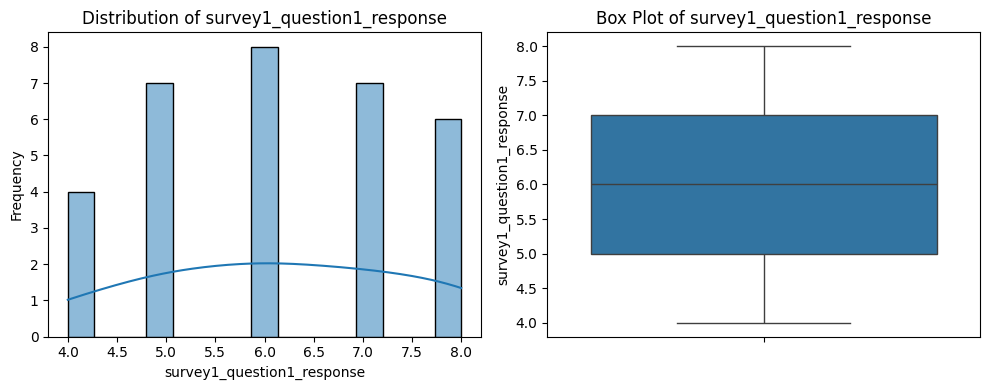

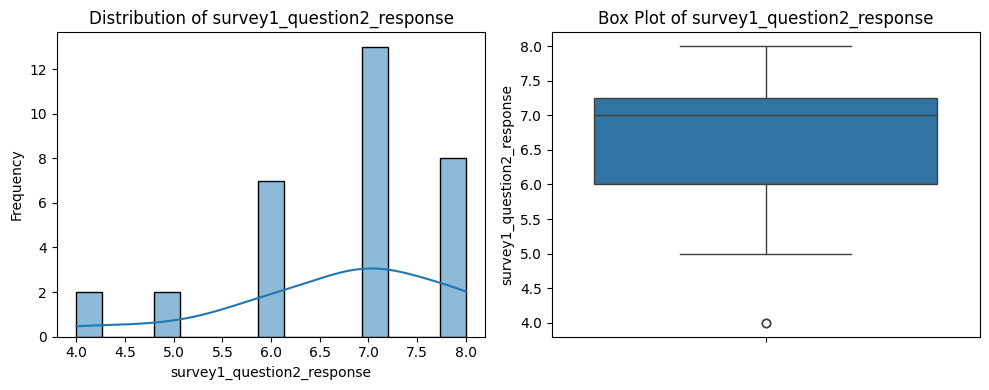

In [18]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

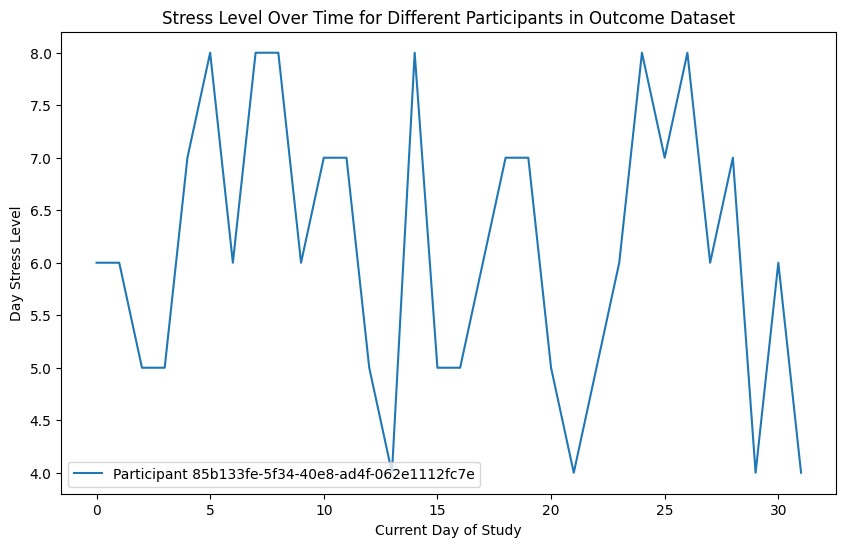

In [19]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

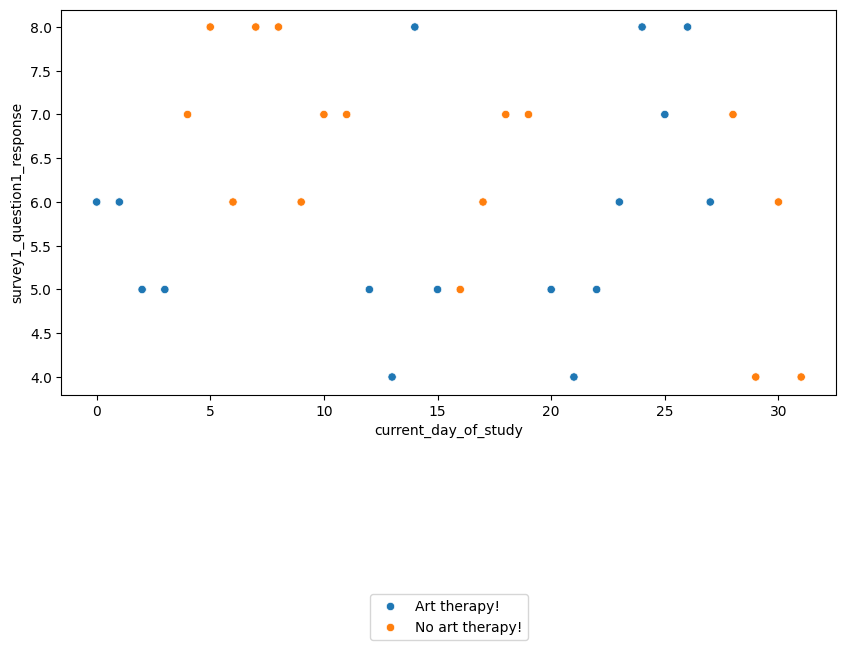

In [20]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

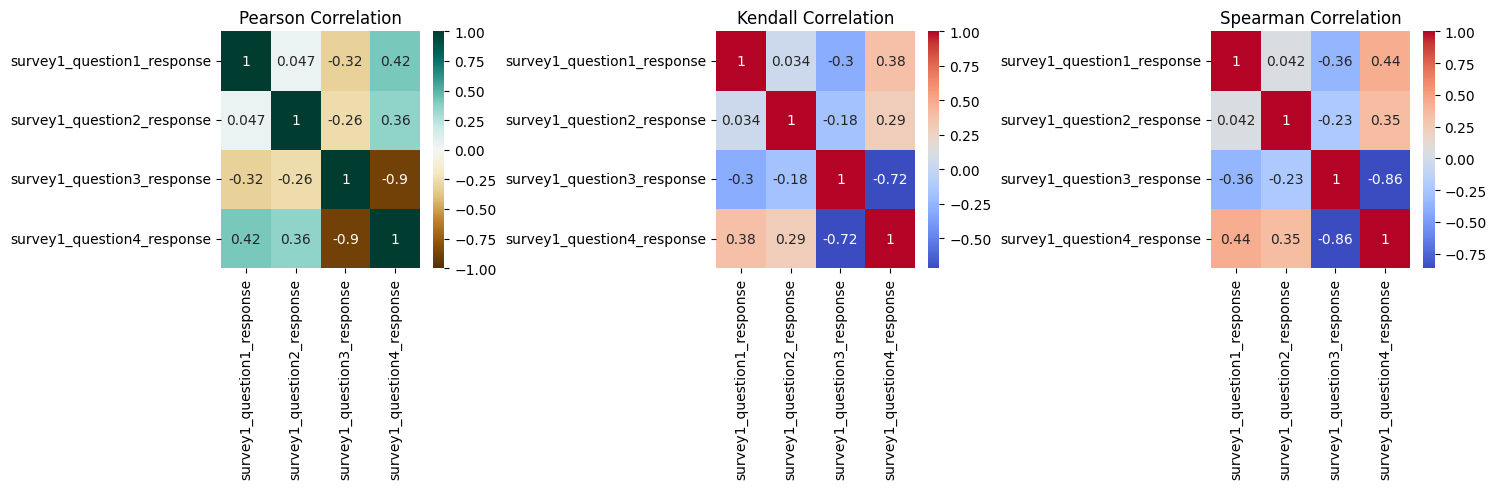

In [21]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Art therapy vs No art therapy 

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of Outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Art therapy!",
        "No art therapy!"
    ])
]

art = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Art therapy!",
    'survey1_question1_response'
]
no_art = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No art therapy!",
    'survey1_question1_response'
]

n_art     = art.count()
n_no_art  = no_art.count()
std_art   = art.std(ddof=1)
std_no_art = no_art.std(ddof=1)

print(f"Art therapy:       n = {n_art}, std = {std_art:.2f}, mean = {art.mean():.2f}")
print(f"No art therapy:    n = {n_no_art}, std = {std_no_art:.2f}, mean = {no_art.mean():.2f}\n")


Art therapy:       n = 16, std = 1.33, mean = 5.81
No art therapy:    n = 16, std = 1.26, mean = 6.44



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Art therapy!",
        "No art therapy!"
    ])
]

art = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Art therapy!",
    'survey1_question2_response'
]
no_art = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No art therapy!",
    'survey1_question2_response'
]

n_art     = art.count()
n_no_art  = no_art.count()
std_art   = art.std(ddof=1)
std_no_art = no_art.std(ddof=1)

print(f"Art therapy:       n = {n_art}, std = {std_art:.2f}, mean = {art.mean():.2f}")
print(f"No art therapy:    n = {n_no_art}, std = {std_no_art:.2f}, mean = {no_art.mean():.2f}\n")


Art therapy:       n = 16, std = 1.26, mean = 6.38
No art therapy:    n = 16, std = 0.85, mean = 7.06



#### Examination of Outcomes: Mean Stress-Relief Score for Art Therapy (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much doing art therapy alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'Did your miracle stress-shrinking method (doing art activities) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes? <b>(Answer ONLY if you have done the art therapy!)</b>'

In [25]:
# 'Did your miracle stress-shrinking method (doing art activities) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes?(Answer ONLY if you have done the art therapy!)'
mean_q3_art_therapy = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Art therapy!",
    'survey1_question3_response'
].mean()
mean_q3_art_therapy.item()


7.1875

**Mean Self-Improvement Score for Art Therapy (Q3): 7.1875:**
On days when the participant did art therapy, he rated Question 3—“Did your miracle stress-shrinking method (doing art activities) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes?”—an average of 7.1875 out of 10, indicating that art therapy provided a substantial benefit.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Doing Art Therapy (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not do art therapy.

In [26]:
df_mea.survey1_question4_text[0]

'When you skipped the method (not doing art activities) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b>(Answer ONLY if the art activities have NOT been done.)</b>\n'

In [27]:
# 'When you skipped the method (not doing art activities) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b>(Answer ONLY if the art activities have NOT been done.)</b>\n'

mean_q4_no_art_therapy = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No art therapy!",
    'survey1_question4_response'
].mean()
mean_q4_no_art_therapy.item()


6.9375

**Mean Stress-Management Difficulty Score Without doing art therapy (Q4): 6.9375:**
On days when the participant skipped art activities, he rated Question 4—“When you skipped the method today, did managing stress feel more like ‘breezing through a sunny park’ or ‘juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles’?”—an average of 6.94 out of 10, indicating that going without art therapy posed a significant challenge in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Art therapy!", "No art therapy!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Art therapy!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.058
Model:                                    OLS   Adj. R-squared:                  0.027
Method:                         Least Squares   F-statistic:                     1.861
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.183
Time:                                15:23:27   Log-Likelihood:                -52.666
No. Observations:                          32   AIC:                             109.3
Df Residuals:                              30   BIC:                             112.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [29]:
# GLSAR Regression with AR(1) errors (Feasible GLS)
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.061
Model:                                  GLSAR   Adj. R-squared:                  0.029
Method:                         Least Squares   F-statistic:                     1.885
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.180
Time:                                15:23:27   Log-Likelihood:                -51.058
No. Observations:                          31   AIC:                             106.1
Df Residuals:                              29   BIC:                             109.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Art Therapy and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 217 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.596  0.508    -1.501      0.422      0.020    0.015     668.0   
rho       0.246  0.202    -0.163      0.603      0.007    0.005     815.0   
sigma     1.320  0.169     1.019      1.651      0.006    0.006     911.0   

          ess_tail  r_hat  
beta_int     590.0    1.0  
rho          660.0    1.0  
sigma        736.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 57.20%
P(beta_int ≤ –0.5) = 57.20%
P(–0.5 < beta_int < 0) = 30.20%
P(beta_int ≥ 0) = 12.60%


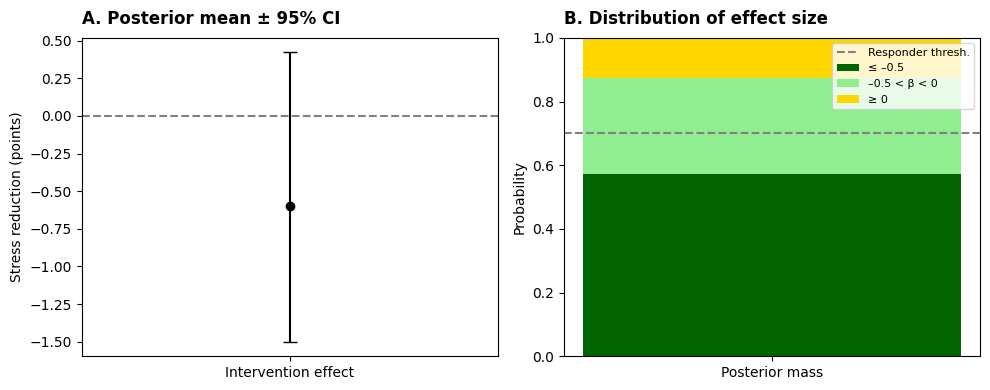

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 777 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.195  0.406    -1.089      0.541      0.018    0.013     504.0   
rho       0.286  0.231    -0.198      0.723      0.011    0.009     445.0   
sigma     0.922  0.117     0.691      1.145      0.005    0.004     509.0   
beta_f1   0.651  0.106     0.464      0.862      0.005    0.003     509.0   

          ess_tail  r_hat  
beta_int     492.0   1.00  
rho          322.0   1.00  
sigma        498.0   1.01  
beta_f1      681.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 21.50%
P(beta_int ≤ –0.5) = 21.50%
P(–0.5 < beta_int < 0) = 45.70%
P(beta_int ≥ 0) = 32.80%


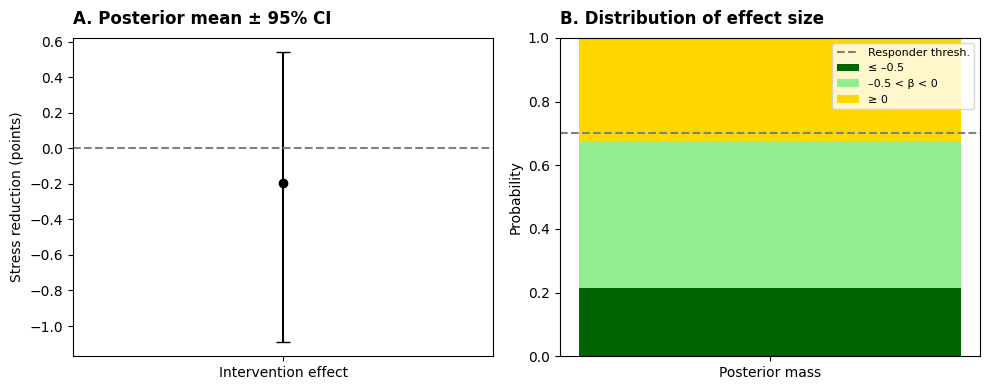

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 900 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.395  0.371    -1.129      0.338      0.013    0.014     766.0   
rho       0.126  0.214    -0.293      0.536      0.010    0.008     503.0   
sigma     1.014  0.151     0.781      1.302      0.007    0.012     489.0   
beta_f2   0.506  0.112     0.275      0.719      0.005    0.004     435.0   

          ess_tail  r_hat  
beta_int     554.0    1.0  
rho          555.0    1.0  
sigma        484.0    1.0  
beta_f2      530.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 37.50%
P(beta_int ≤ –0.5) = 37.50%
P(–0.5 < beta_int < 0) = 48.90%
P(beta_int ≥ 0) = 13.60%


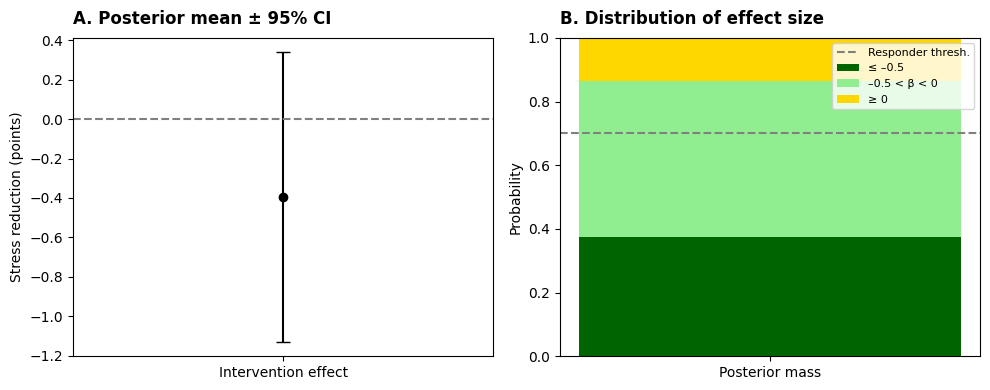

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1329 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.230  0.359    -0.953      0.436      0.016    0.010     523.0   
rho       0.230  0.233    -0.170      0.734      0.009    0.009     665.0   
sigma     0.931  0.133     0.679      1.189      0.005    0.006     670.0   
beta_f1   0.495  0.197     0.119      0.873      0.009    0.007     497.0   
beta_f2   0.157  0.168    -0.169      0.502      0.007    0.005     556.0   

          ess_tail  r_hat  
beta_int     614.0   1.01  
rho          443.0   1.00  
sigma        418.0   1.00  
beta_f1      412.0   1.01  
beta_f2      558.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 23.90%
P(beta_int ≤ –0.5) = 23.90%
P(–0.5 < beta_int < 0) = 48.90%
P(beta_int ≥ 0) = 27.20%


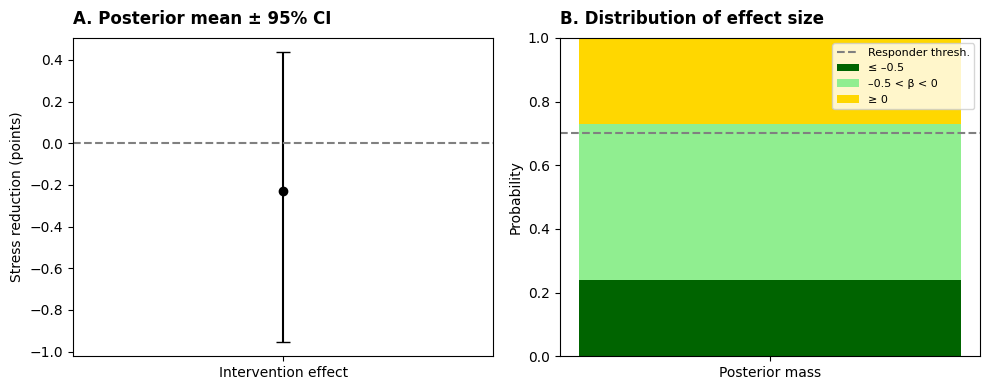

In [ ]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Art therapy!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    # Panel B
    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 275 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.653  0.551    -1.833      0.345      0.021    0.018     689.0   
rho       0.263  0.204    -0.131      0.643      0.007    0.006     782.0   
sigma     1.348  0.186     0.986      1.708      0.007    0.006     771.0   

          ess_tail  r_hat  
beta_int     645.0   1.00  
rho          597.0   1.01  
sigma        643.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 61.20%
P(beta_int ≤ –0.5) = 61.20%
P(–0.5 < beta_int < 0) = 27.30%
P(beta_int ≥ 0) = 11.50%


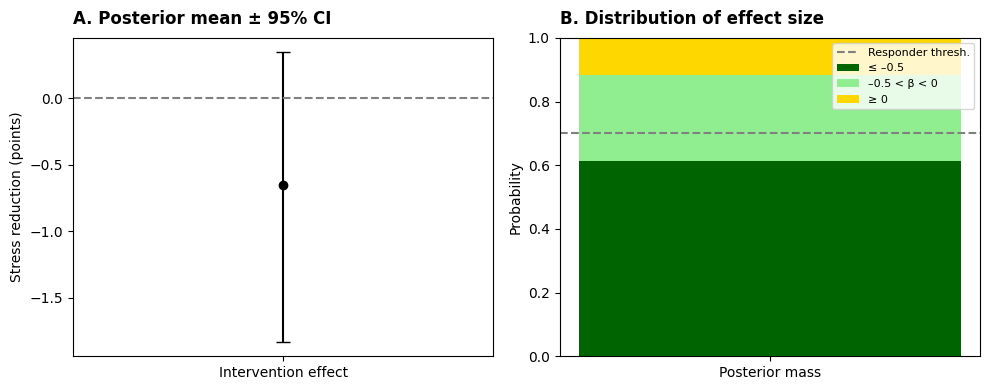


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 509 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.169  0.451    -1.118      0.658      0.019    0.018     563.0   
rho       0.287  0.241    -0.174      0.765      0.010    0.010     664.0   
sigma     0.947  0.131     0.729      1.224      0.007    0.006     454.0   
beta_f1   0.675  0.117     0.444      0.897      0.005    0.004     523.0   

          ess_tail  r_hat  
beta_int     519.0    1.0  
rho          343.0    1.0  
sigma        407.0    1.0  
beta_f1      561.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 21.30%
P(beta_int ≤ –0.5) = 21.30%
P(–0.5 < beta_int < 0) = 43.70%
P(beta_int ≥ 0) = 35.00%


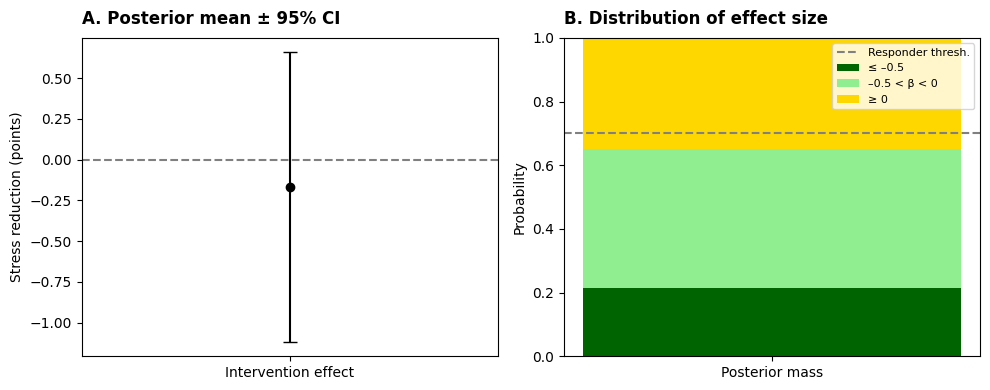


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 589 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.335  0.396    -1.182      0.401      0.017    0.015     531.0   
rho       0.116  0.231    -0.331      0.565      0.011    0.008     453.0   
sigma     1.016  0.140     0.764      1.304      0.006    0.005     563.0   
beta_f2   0.554  0.107     0.342      0.756      0.005    0.004     382.0   

          ess_tail  r_hat  
beta_int     523.0    1.0  
rho          376.0    1.0  
sigma        518.0    1.0  
beta_f2      393.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 32.60%
P(beta_int ≤ –0.5) = 32.60%
P(–0.5 < beta_int < 0) = 47.50%
P(beta_int ≥ 0) = 19.90%


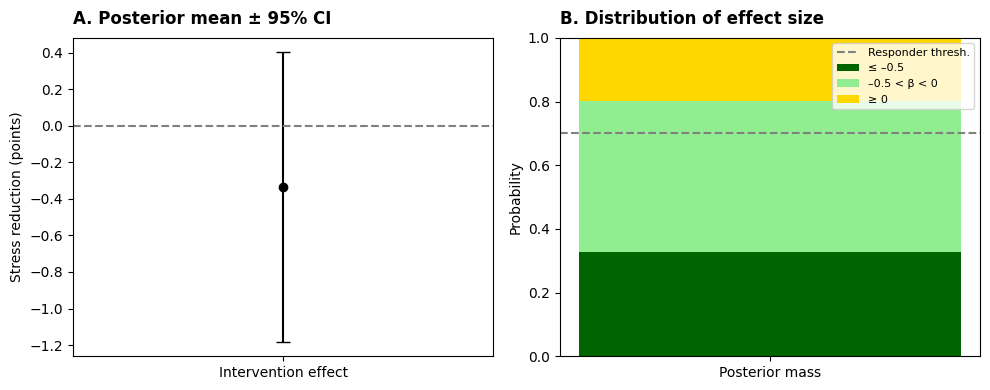


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 522 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.191  0.405    -1.032      0.590      0.018    0.016     533.0   
rho       0.217  0.270    -0.208      0.819      0.027    0.040     177.0   
sigma     0.939  0.127     0.715      1.200      0.005    0.005     671.0   
beta_f1   0.513  0.200     0.185      0.986      0.010    0.007     425.0   
beta_f2   0.171  0.176    -0.185      0.520      0.008    0.007     471.0   

          ess_tail  r_hat  
beta_int     488.0   1.00  
rho           58.0   1.01  
sigma        613.0   1.00  
beta_f1      433.0   1.00  
beta_f2      490.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 20.60%
P(beta_int ≤ –0.5) = 20.60%
P(–0.5 < beta_int < 0) = 47.90%
P(beta_int ≥ 0) = 31.50%


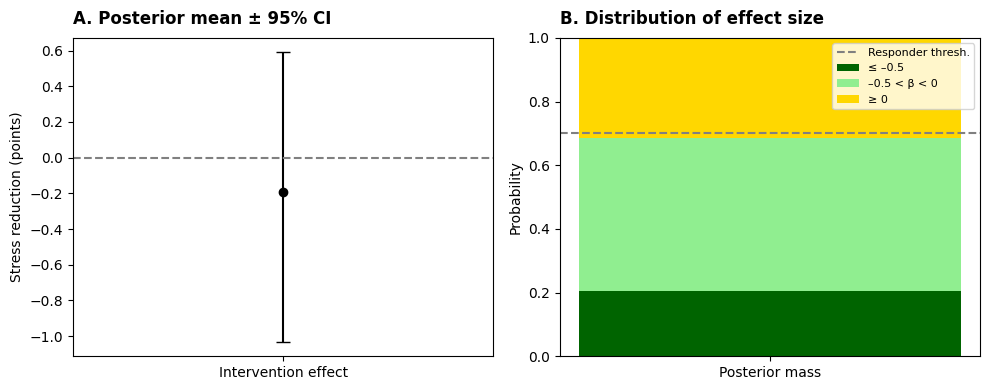

In [31]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Art therapy!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)